In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',80)

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
stopwords_eng = stopwords.words('english')

# Import Data

Dataset accessed from: https://www.kaggle.com/benhamner/clinton-trump-tweets

In [14]:
tweets_df = pd.read_csv('Data/tweets_elections_2016.csv')

In [15]:
tweets_df.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the plans into action that will m...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,"{'media': [{'display_url': 'pic.twitter.com/XreEY9OicG', 'expanded_url': 'ht...","{'media': [{'display_url': 'pic.twitter.com/XreEY9OicG', 'sizes': {'medium':..."
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes was ""smart."" You know what I ...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,"{'media': [{'display_url': 'pic.twitter.com/t0xmBfj7zF', 'sizes': {'medium':...","{'media': [{'display_url': 'pic.twitter.com/t0xmBfj7zF', 'sizes': {'medium':..."
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her vision and command during las...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'name': 'President Obama', 'id':...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't do. \n\nMake sure you're read...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,"{'media': [{'display_url': 'pic.twitter.com/Q3Ymbb7UNy', 'expanded_url': 'ht...","{'media': [{'display_url': 'pic.twitter.com/Q3Ymbb7UNy', 'sizes': {'thumb': ..."
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd confront racial injustice. Only ...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [{'display_url': 'hrc.io/2cTNXP...",NaN


In [16]:
tweets_df.shape

(6444, 28)

In [17]:
tweets_df = tweets_df[[ 'handle', 'text', 'is_retweet', 'original_author', 
                 'time', 'lang', 'retweet_count', 'favorite_count']]

In [18]:
tweets_df.head()

,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count
0,HillaryClinton,The question in this election: Who can put the plans into action that will m...,False,NaN,2016-09-28T00:22:34,en,218,651
1,HillaryClinton,"Last night, Donald Trump said not paying taxes was ""smart."" You know what I ...",True,timkaine,2016-09-27T23:45:00,en,2445,5308
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her vision and command during las...,True,POTUS,2016-09-27T23:26:40,en,7834,27234
3,HillaryClinton,"If we stand together, there's nothing we can't do. \n\nMake sure you're read...",False,NaN,2016-09-27T23:08:41,en,916,2542
4,HillaryClinton,Both candidates were asked about how they'd confront racial injustice. Only ...,False,NaN,2016-09-27T22:30:27,en,859,2882


In [19]:
tweets_df['lang'].value_counts()

en     6248
es      105
und      82
da        3
fr        2
tl        2
fi        1
et        1
Name: lang, dtype: int64

In [20]:
tweets_df = tweets_df[tweets_df['lang'] == 'en']

In [21]:
tweets_df.shape

(6248, 8)

In [22]:
tweets_df.head()

,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count
0,HillaryClinton,The question in this election: Who can put the plans into action that will m...,False,NaN,2016-09-28T00:22:34,en,218,651
1,HillaryClinton,"Last night, Donald Trump said not paying taxes was ""smart."" You know what I ...",True,timkaine,2016-09-27T23:45:00,en,2445,5308
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her vision and command during las...,True,POTUS,2016-09-27T23:26:40,en,7834,27234
3,HillaryClinton,"If we stand together, there's nothing we can't do. \n\nMake sure you're read...",False,NaN,2016-09-27T23:08:41,en,916,2542
4,HillaryClinton,Both candidates were asked about how they'd confront racial injustice. Only ...,False,NaN,2016-09-27T22:30:27,en,859,2882


# NLTK text preprocess

In [23]:
def clean_tweet(tweet):
    tweet = re.sub('RT','',tweet)
    tweet = re.sub('@','',tweet)
    tweet = re.sub('#','',tweet)
    tweet = re.sub('https?://[A-Za-z0-9./]*','',tweet)
    tweet = re.sub('\n','',tweet)
    return tweet

In [24]:
# lemmatization function
lemmatizer = WordNetLemmatizer()
def lemmatize_tweet(tweet):
    lemmatized_tweet = []
    for word in tweet:
        lemmatized_tweet.append(lemmatizer.lemmatize(word, pos='v'))
    return lemmatized_tweet

# stemming function
porter = PorterStemmer()
def stem_tweet(tweet):
    stemmed_tweet = []
    for word in tweet:
        stemmed_tweet.append(porter.stem(word))
    return stemmed_tweet


# remove stopwords function
def remove_stopwords(tweet):
    tweet_witout_stops = []
    for word in tweet:
        if word not in stopwords_eng:
            tweet_witout_stops.append(word)
    return tweet_witout_stops

In [25]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_tweet)

<ipython-input-25-723cdd9efce0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_tweet)


In [27]:
# make all text lowercase
tweets_df['cleaned_text'] = tweets_df['cleaned_text'].apply(lambda x: x.lower())

<ipython-input-27-a271d70e467d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['cleaned_text'] = tweets_df['cleaned_text'].apply(lambda x: x.lower())


In [30]:
# remove punctuations and numbers and emoji
tweets_df['cleaned_text'] = tweets_df['cleaned_text'].str.replace("[^a-zA-z]", " ")

<ipython-input-30-7b644cf159d7>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['cleaned_text'] = tweets_df['cleaned_text'].str.replace("[^a-zA-z]", " ")
<ipython-input-30-7b644cf159d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['cleaned_text'] = tweets_df['cleaned_text'].str.replace("[^a-zA-z]", " ")


In [32]:
#tokenize text
tweets_df['tokenized_text'] = tweets_df['cleaned_text'].apply(lambda x: word_tokenize(x))

<ipython-input-32-6d98780dd824>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokenized_text'] = tweets_df['cleaned_text'].apply(lambda x: word_tokenize(x))


In [33]:
#remove stopwords
tweets_df['tokenized_text'] = tweets_df['tokenized_text'].apply(remove_stopwords)

<ipython-input-33-a124637c410b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokenized_text'] = tweets_df['tokenized_text'].apply(remove_stopwords)


In [34]:
#lemmatize text
tweets_df['lemmatized_text'] = tweets_df['tokenized_text']. apply(lemmatize_tweet)

In [35]:
#stem text
tweets_df['stemmed_text'] = tweets_df['lemmatized_text'].apply(stem_tweet)

In [36]:
#de tokenize text
tweets_df['lemmatized_string'] = tweets_df['lemmatized_text'].apply(lambda x: ' '.join(x))
tweets_df['stemmed_string'] = tweets_df['stemmed_text'].apply(lambda x: ' '.join(x))

In [37]:
tweets_df.head()

,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count,cleaned_text,tokenized_text,lemmatized_text,stemmed_text,lemmatized_string,stemmed_string
0,HillaryClinton,The question in this election: Who can put the plans into action that will m...,False,NaN,2016-09-28T00:22:34,en,218,651,the question in this election who can put the plans into action that will m...,"[question, election, put, plans, action, make, life, better]","[question, election, put, plan, action, make, life, better]","[question, elect, put, plan, action, make, life, better]",question election put plan action make life better,question elect put plan action make life better
1,HillaryClinton,"Last night, Donald Trump said not paying taxes was ""smart."" You know what I ...",True,timkaine,2016-09-27T23:45:00,en,2445,5308,last night donald trump said not paying taxes was smart you know what i ...,"[last, night, donald, trump, said, paying, taxes, smart, know, call, unpatri...","[last, night, donald, trump, say, pay, tax, smart, know, call, unpatriotic]","[last, night, donald, trump, say, pay, tax, smart, know, call, unpatriot]",last night donald trump say pay tax smart know call unpatriotic,last night donald trump say pay tax smart know call unpatriot
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her vision and command during las...,True,POTUS,2016-09-27T23:26:40,en,7834,27234,couldn t be more proud of hillaryclinton her vision and command during last...,"[proud, hillaryclinton, vision, command, last, night, debate, showed, ready,...","[proud, hillaryclinton, vision, command, last, night, debate, show, ready, n...","[proud, hillaryclinton, vision, command, last, night, debat, show, readi, ne...",proud hillaryclinton vision command last night debate show ready next potus,proud hillaryclinton vision command last night debat show readi next potu
3,HillaryClinton,"If we stand together, there's nothing we can't do. \n\nMake sure you're read...",False,NaN,2016-09-27T23:08:41,en,916,2542,if we stand together there s nothing we can t do make sure you re ready to...,"[stand, together, nothing, make, sure, ready, vote]","[stand, together, nothing, make, sure, ready, vote]","[stand, togeth, noth, make, sure, readi, vote]",stand together nothing make sure ready vote,stand togeth noth make sure readi vote
4,HillaryClinton,Both candidates were asked about how they'd confront racial injustice. Only ...,False,NaN,2016-09-27T22:30:27,en,859,2882,both candidates were asked about how they d confront racial injustice only ...,"[candidates, asked, confront, racial, injustice, one, real, answer]","[candidates, ask, confront, racial, injustice, one, real, answer]","[candid, ask, confront, racial, injustic, one, real, answer]",candidates ask confront racial injustice one real answer,candid ask confront racial injustic one real answer


In [38]:
tweets_df['handle'].value_counts()

realDonaldTrump    3131
HillaryClinton     3117
Name: handle, dtype: int64

In [41]:
trump_mentions = len(tweets_df[tweets_df['handle'] == 'realDonaldTrump'])
print(f'Donald Trump mentions: {trump_mentions}')

hillary_mentions = len(tweets_df[tweets_df['handle'] == 'HillaryClinton'])
print(f'Hillary Clinton mentions: {hillary_mentions}')

Donald Trump mentions: 3131
Hillary Clinton mentions: 3117


# NLTK sentiment Analysis

In [42]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [43]:
sid = SentimentIntensityAnalyzer()

In [44]:
def tweet_polarity(tweet):
    return sid.polarity_scores(tweet)

In [76]:
#tweets_df['Polarity'] = tweets_df['Cleaned Tweet'].apply(tweet_polarity)
tweets_df['Polarity'] = tweets_df['lemmatized_string'].apply(tweet_polarity)

In [77]:
#tweets_df.drop('Tweet', axis=1, inplace=True)

def sentimentVerdict(polarity):
    #print(polarity['compound'])
    if polarity['compound'] >= 0.05:
        return "Positive"
    elif polarity['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [78]:
tweets_df['Sentiment'] = tweets_df['Polarity'].apply(sentimentVerdict)

In [79]:
tweets_df.head()

,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count,cleaned_text,tokenized_text,lemmatized_text,stemmed_text,lemmatized_string,stemmed_string,Polarity,Sentiment
0,HillaryClinton,The question in this election: Who can put the plans into action that will m...,False,NaN,2016-09-28T00:22:34,en,218,651,the question in this election who can put the plans into action that will m...,"[question, election, put, plans, action, make, life, better]","[question, election, put, plan, action, make, life, better]","[question, elect, put, plan, action, make, life, better]",question election put plan action make life better,question elect put plan action make life better,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.4404}",Positive
1,HillaryClinton,"Last night, Donald Trump said not paying taxes was ""smart."" You know what I ...",True,timkaine,2016-09-27T23:45:00,en,2445,5308,last night donald trump said not paying taxes was smart you know what i ...,"[last, night, donald, trump, said, paying, taxes, smart, know, call, unpatri...","[last, night, donald, trump, say, pay, tax, smart, know, call, unpatriotic]","[last, night, donald, trump, say, pay, tax, smart, know, call, unpatriot]",last night donald trump say pay tax smart know call unpatriotic,last night donald trump say pay tax smart know call unpatriot,"{'neg': 0.107, 'neu': 0.687, 'pos': 0.206, 'compound': 0.3182}",Positive
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her vision and command during las...,True,POTUS,2016-09-27T23:26:40,en,7834,27234,couldn t be more proud of hillaryclinton her vision and command during last...,"[proud, hillaryclinton, vision, command, last, night, debate, showed, ready,...","[proud, hillaryclinton, vision, command, last, night, debate, show, ready, n...","[proud, hillaryclinton, vision, command, last, night, debat, show, readi, ne...",proud hillaryclinton vision command last night debate show ready next potus,proud hillaryclinton vision command last night debat show readi next potu,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'compound': 0.765}",Positive
3,HillaryClinton,"If we stand together, there's nothing we can't do. \n\nMake sure you're read...",False,NaN,2016-09-27T23:08:41,en,916,2542,if we stand together there s nothing we can t do make sure you re ready to...,"[stand, together, nothing, make, sure, ready, vote]","[stand, together, nothing, make, sure, ready, vote]","[stand, togeth, noth, make, sure, readi, vote]",stand together nothing make sure ready vote,stand togeth noth make sure readi vote,"{'neg': 0.449, 'neu': 0.551, 'pos': 0.0, 'compound': -0.4717}",Negative
4,HillaryClinton,Both candidates were asked about how they'd confront racial injustice. Only ...,False,NaN,2016-09-27T22:30:27,en,859,2882,both candidates were asked about how they d confront racial injustice only ...,"[candidates, asked, confront, racial, injustice, one, real, answer]","[candidates, ask, confront, racial, injustice, one, real, answer]","[candid, ask, confront, racial, injustic, one, real, answer]",candidates ask confront racial injustice one real answer,candid ask confront racial injustic one real answer,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.6597}",Negative


In [80]:
myindex = ['Donald Trump', 'Hillary Clinton']

In [81]:
mycolumns = ['Positive', 'Neutral', 'Negative']

In [82]:
sentimet_df = pd.DataFrame(index=myindex, columns=mycolumns)

In [83]:
positive_trump = len(tweets_df[(tweets_df['handle'] == 'realDonaldTrump') & (tweets_df['Sentiment'] == 'Positive')])
neutral_trump = len(tweets_df[(tweets_df['handle'] == 'realDonaldTrump') & (tweets_df['Sentiment'] == 'Neutral')])
negative_trump = len(tweets_df[(tweets_df['handle'] == 'realDonaldTrump') & (tweets_df['Sentiment'] == 'Negative')])

positive_hillary = len(tweets_df[(tweets_df['handle'] == 'HillaryClinton') & (tweets_df['Sentiment'] == 'Positive')])
neutral_hillary = len(tweets_df[(tweets_df['handle'] == 'HillaryClinton') & (tweets_df['Sentiment'] == 'Neutral')])
negative_hillary = len(tweets_df[(tweets_df['handle'] == 'HillaryClinton') & (tweets_df['Sentiment'] == 'Negative')])

In [84]:
sentimet_df.at['Donald Trump', 'Positive'] = positive_trump
sentimet_df.at['Donald Trump', 'Neutral'] = neutral_trump
sentimet_df.at['Donald Trump', 'Negative'] = negative_trump

sentimet_df.at['Hillary Clinton', 'Positive'] = positive_hillary
sentimet_df.at['Hillary Clinton', 'Neutral'] = neutral_hillary
sentimet_df.at['Hillary Clinton', 'Negative'] = negative_hillary

sentimet_df

,Positive,Neutral,Negative
Donald Trump,1831,455,845
Hillary Clinton,1524,729,864


# Estimations of elections results

In [85]:
labels = list(sentimet_df.index)
labels.append('Others')
percentage_trump = round(((positive_trump + negative_hillary + neutral_trump*0.3)/len(tweets_df))*100, 2)
percentage_hillary = round(((positive_hillary + negative_trump + neutral_hillary*0.3)/len(tweets_df))*100, 2)
percentage_others = round(100 - percentage_hillary - percentage_trump, 2)
data = [percentage_trump, percentage_hillary, percentage_others]

In [86]:
labels

['Donald Trump', 'Hillary Clinton', 'Others']

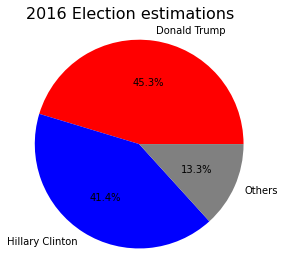

In [88]:
fig, axes = plt.subplots(figsize=(10,4))
axes.pie(data, labels=labels, autopct='%1.1f%%',radius=1.2,colors=['red','blue','gray'])
fig.suptitle("2016 Election estimations",fontsize=16)
fig.savefig('Plots/estimations_2016.png')